# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Some statistics about our dataset
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [4]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [5]:
#Understand data, read head and tail of each dataset
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.tail()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
891216,825761,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,15.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,11.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,NaN,NaN,NaN,NaN,17.0,3.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,17.0,NaN,NaN,NaN,20.0,7.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1
891220,825787,-1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,10.0,...,3.0,8.0,10.0,7.0,6.0,3.0,4.0,3,1,4


In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
customers.tail()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
191647,154561,1,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,...,5.0,6.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
191648,154563,-1,2.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,4.0,NaN,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,2,4
191649,148813,2,1.0,15.0,NaN,NaN,NaN,NaN,10.0,1.0,...,5.0,3.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
191650,148852,3,1.0,13.0,NaN,NaN,NaN,NaN,13.0,4.0,...,1.0,4.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,2,3
191651,148883,3,1.0,0.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,3.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,2


In [9]:
#count how many Nan values we have in each column
nan_values_azdias = ((azdias.isnull().sum(axis = 0) / azdias.shape[0]) *100).sort_values(ascending=False)
nan_values_azdias

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
KBA05_MOD2                     14.959701
KBA05_SEG1                     14.959701
KBA05_MOD1                     14.959701
KBA05_MAXVORB                  14.959701
KBA05_MAXSEG    

In [10]:
#count how many Nan values we have in each column
nan_values_customers = ((customers.isnull().sum(axis = 0) / customers.shape[0]) *100).sort_values(ascending=False)
nan_values_customers

ALTER_KIND4                  99.876860
ALTER_KIND3                  99.334732
ALTER_KIND2                  97.338927
ALTER_KIND1                  93.860748
KK_KUNDENTYP                 58.406382
EXTSEL992                    44.498883
KBA05_SEG7                   29.209192
KBA05_KW1                    29.209192
KBA05_SEG4                   29.209192
KBA05_SEG5                   29.209192
KBA05_SEG6                   29.209192
KBA05_MAXAH                  29.209192
KBA05_SEG8                   29.209192
KBA05_KW2                    29.209192
KBA05_VORB0                  29.209192
KBA05_KRSZUL                 29.209192
KBA05_VORB1                  29.209192
KBA05_KRSVAN                 29.209192
KBA05_KRSOBER                29.209192
KBA05_SEG9                   29.209192
MOBI_REGIO                   29.209192
KBA05_KW3                    29.209192
KBA05_SEG3                   29.209192
KBA05_KRSHERST3              29.209192
KBA05_MAXBJ                  29.209192
KBA05_MAXHERST           

In [11]:
azdias.describe(include=['O']) #Statistics for categorical variables

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,792242,792242,792242,634108,798073,798073
unique,45,19,43,35,5162,2
top,6B,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,56672,78023,77576,195338,383738,629528


In [12]:
#See unique values and how they are spread in the dataset 
for i in azdias.columns:
    print(i,'\n', azdias[i].unique(), len(azdias[i].unique()))

LNR 
 [910215 910220 910225 ..., 825772 825776 825787] 891221
AGER_TYP 
 [-1  2  3  0  1] 5
AKT_DAT_KL 
 [ nan   9.   1.   5.   8.   7.   6.   4.   3.   2.] 10
ALTER_HH 
 [ nan   0.  17.  13.  20.  10.  14.  16.  21.  11.  19.  15.   9.  18.   8.
   7.  12.   4.   3.   6.   5.   2.   1.] 23
ALTER_KIND1 
 [ nan  17.  10.  18.  13.  16.  11.   6.   8.   9.  15.  14.   7.  12.   4.
   3.   5.   2.] 18
ALTER_KIND2 
 [ nan  13.   8.  12.  10.   7.  16.  15.  14.  17.   5.   9.  18.  11.   6.
   4.   3.   2.] 18
ALTER_KIND3 
 [ nan  10.  18.  17.  16.   8.  15.   9.  12.  13.  14.  11.   7.   5.   6.
   4.] 16
ALTER_KIND4 
 [ nan  10.   9.  16.  14.  13.  11.  18.  17.  15.   8.  12.   7.] 13
ALTERSKATEGORIE_FEIN 
 [ nan  21.  17.  13.  14.  10.  16.  20.  11.  19.  15.  18.   9.  22.  12.
   0.   8.   7.  23.   4.  24.   6.   3.   2.   5.  25.   1.] 27
ANZ_HAUSHALTE_AKTIV 
 [  nan   11.   10.    1.    3.    5.    4.    6.    2.    9.    0.   14.
   13.    8.    7.   44.   25.   36.   16.  2

In [13]:
#Just take a look to see if there's some reason to not drop this columns with more than 85% of Nan values
not_null = azdias[azdias['ALTER_KIND4'].notnull() >= 1]
not_null.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
2832,430037,-1,1.0,17.0,8.0,8.0,10.0,10.0,17.0,1.0,...,NaN,3.0,5.0,4.0,1.0,9.0,8.0,2,2,3
6099,732973,-1,1.0,18.0,6.0,6.0,9.0,9.0,18.0,2.0,...,NaN,2.0,3.0,5.0,1.0,9.0,8.0,4,1,1
6115,960770,-1,9.0,17.0,8.0,10.0,16.0,16.0,22.0,1.0,...,NaN,4.0,7.0,10.0,1.0,5.0,3.0,1,1,1
7956,659211,-1,1.0,21.0,12.0,12.0,14.0,14.0,17.0,8.0,...,NaN,4.0,7.0,9.0,1.0,9.0,3.0,4,2,2
8437,781088,-1,1.0,19.0,8.0,11.0,12.0,13.0,19.0,1.0,...,1.0,2.0,3.0,4.0,1.0,8.0,5.0,4,1,4


In [14]:
#Lets analyse columns with Nan values between 50 and 85 percent 
azdias_missing_features_50_85 = nan_values_azdias[(nan_values_azdias > 50) & ( nan_values_azdias < 85)].index
azdias[azdias_missing_features_50_85].head(20)

,EXTSEL992,KK_KUNDENTYP
0,NaN,NaN
1,NaN,NaN
2,14.0,NaN
3,31.0,NaN
4,NaN,1.0
5,20.0,3.0
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,56.0,6.0


count    306609.000000
mean          3.410640
std           1.628844
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: KK_KUNDENTYP, dtype: float64


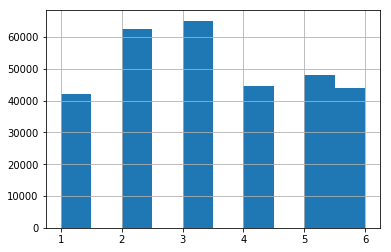

In [15]:
#EXTSEL992 has a big variaty of values so it's better to just drop it, KK_KUNDENTYP will be dropped but maybe we can have
#another approach if it's necessary in the future
print(azdias['KK_KUNDENTYP'].describe())
azdias['KK_KUNDENTYP'].hist()

In [16]:
#Lets analyse variable with Nan values between 20 to 50 percent
azdias_missing_features_20_50 = nan_values_azdias[(nan_values_azdias > 20) &( nan_values_azdias < 50)].index
azdias[azdias_missing_features_20_50].head()

,ALTERSKATEGORIE_FEIN,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_VERSI_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,D19_SOZIALES,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17.0,D19_UNBEKANNT,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
3,13.0,D19_UNBEKANNT,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
4,14.0,D19_SCHUHE,0.0,0.0,10.0,0.0,10.0,1.0,0.0,10.0


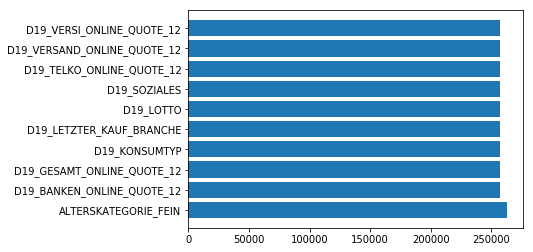

In [17]:
#see how many nan values we have and how it's spread in all categories
plt.barh(azdias[azdias_missing_features_20_50].isna().sum().index, azdias[azdias_missing_features_20_50].isna().sum())
plt.show()

In [18]:
#Open the features and attributes dataset to understand what zero means
values = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
attributes = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')

In [19]:
values.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [20]:
#fill the cell withou value with the value from the lasts cell, this will make it easier to filter the other columns
values["Description"] = values["Description"].ffill()
values["Attribute"] = values["Attribute"].ffill()
values.drop('Unnamed: 0', axis=1, inplace=True)
values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [21]:
values.set_index('Attribute', inplace=True)
values.head()

,Description,Value,Meaning
Attribute,,,
AGER_TYP,best-ager typology,-1,unknown
AGER_TYP,best-ager typology,0,no classification possible
AGER_TYP,best-ager typology,1,passive elderly
AGER_TYP,best-ager typology,2,cultural elderly
AGER_TYP,best-ager typology,3,experience-driven elderly


In [22]:
#Lets see how many of the values are zeros, maybe even not being Nan we can drop all column
percent_20_50 = pd.DataFrame((azdias[azdias_missing_features_20_50].isin([0]).sum() / azdias.shape[0]) *100, columns=['Percent'])
percent_20_50


,Percent
ALTERSKATEGORIE_FEIN,4.621525
D19_LETZTER_KAUF_BRANCHE,0.000000
D19_LOTTO,55.075340
D19_VERSI_ONLINE_QUOTE_12,70.965787
D19_BANKEN_ONLINE_QUOTE_12,66.074969
D19_SOZIALES,56.756742
D19_GESAMT_ONLINE_QUOTE_12,44.105222
D19_KONSUMTYP,0.000000
D19_TELKO_ONLINE_QUOTE_12,71.062060
D19_VERSAND_ONLINE_QUOTE_12,46.830921


In [23]:
not_found = [] 
for val in azdias_missing_features_20_50:
    if attributes[attributes['Attribute'] == val]['Description'].empty:    
        not_found.append(val)
print("Not found on list of attributes:", pd.DataFrame(not_found))

Not found on list of attributes:                            0
0       ALTERSKATEGORIE_FEIN
1   D19_LETZTER_KAUF_BRANCHE
2                  D19_LOTTO
3  D19_VERSI_ONLINE_QUOTE_12
4               D19_SOZIALES
5  D19_TELKO_ONLINE_QUOTE_12


In [24]:
#See the columns we have a description on values dataset
for val in azdias_missing_features_20_50:
    try:
        print(pd.DataFrame(values.loc[[val],['Value','Meaning']]))
    except:
        pass

                           Value  \
Attribute                          
D19_BANKEN_ONLINE_QUOTE_12     0   
D19_BANKEN_ONLINE_QUOTE_12     1   
D19_BANKEN_ONLINE_QUOTE_12     2   
D19_BANKEN_ONLINE_QUOTE_12     3   
D19_BANKEN_ONLINE_QUOTE_12     4   
D19_BANKEN_ONLINE_QUOTE_12     5   
D19_BANKEN_ONLINE_QUOTE_12     6   
D19_BANKEN_ONLINE_QUOTE_12     7   
D19_BANKEN_ONLINE_QUOTE_12     8   
D19_BANKEN_ONLINE_QUOTE_12     9   
D19_BANKEN_ONLINE_QUOTE_12    10   

                                                                      Meaning  
Attribute                                                                      
D19_BANKEN_ONLINE_QUOTE_12   no Online-transactions within the last 12 months  
D19_BANKEN_ONLINE_QUOTE_12  10% Online-transactions within the last 12 months  
D19_BANKEN_ONLINE_QUOTE_12  20% Online-transactions within the last 12 months  
D19_BANKEN_ONLINE_QUOTE_12  30% Online-transactions within the last 12 months  
D19_BANKEN_ONLINE_QUOTE_12  40% Online-transactions

In [25]:
#See all kind of values in each column
for i in azdias_missing_features_20_50:
    print(i,'\n', azdias[i].unique())

ALTERSKATEGORIE_FEIN 
 [ nan  21.  17.  13.  14.  10.  16.  20.  11.  19.  15.  18.   9.  22.  12.
   0.   8.   7.  23.   4.  24.   6.   3.   2.   5.  25.   1.]
D19_LETZTER_KAUF_BRANCHE 
 [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG' 'D19_BANKEN_LOKAL']
D19_LOTTO 
 [ nan   0.   6.   7.   5.   3.   4.   2.   1.]
D19_VERSI_ONLINE_QUOTE_12 
 [ nan   0.  10.   5.   7.   8.   6.   3.   9.]
D19_BANKEN_ONLINE_QUOTE_12 
 [ nan   0.  10.   8.   5.   9.

In [26]:
#See the percentage of every value on the attributes we found description
#the most person didnt make internet transactions but a good part of them made 100 percent online
valid_attribute_list = ['D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12']
list_percent = []
for num in range(11):
        percentage = (azdias[valid_attribute_list].isin([num]).sum() / azdias.shape[0]) *100
        list_percent.append(percentage)
#        print('Percentage of ',num, 'values:\n', percentage)
for i in valid_attribute_list:
    print(i, azdias[i].unique())
pd.DataFrame(list_percent)

D19_BANKEN_ONLINE_QUOTE_12 [ nan   0.  10.   8.   5.   9.   7.   6.   3.   4.   2.   1.]
D19_GESAMT_ONLINE_QUOTE_12 [ nan   0.  10.   7.   9.   5.   8.   6.   3.   4.   2.   1.]
D19_KONSUMTYP [ nan   9.   1.   4.   3.   6.   5.   2.]
D19_VERSAND_ONLINE_QUOTE_12 [ nan   0.  10.   7.   5.   9.   3.   8.   6.   4.   2.   1.]


,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_VERSAND_ONLINE_QUOTE_12
0,66.074969,44.105222,0.000000,46.830921
1,0.000224,0.097507,13.230388,0.063060
2,0.003927,0.119611,5.534430,0.084266
3,0.024685,0.397544,5.983925,0.297681
4,0.002020,0.114113,8.781436,0.082920
5,0.043872,1.180066,2.740286,0.901460
6,0.005610,0.188393,6.346574,0.121182
7,0.024012,0.776799,0.000000,0.552052
8,0.019299,1.062251,0.000000,0.720248
9,0.007518,0.678395,28.533439,0.441080


Most of the values are 0 or 10, except in KOMSUMTYP column, 0 is about no online transaction and 10 is 100 percent online transactions

In [27]:
#Now lets see the columns with more than 10 and less than 20 percent of Nan
azdias_missing_features_10_20 = nan_values_azdias[(nan_values_azdias > 10) & ( nan_values_azdias < 20)].index
azdias[azdias_missing_features_10_20].head()

,KBA05_MOTOR,KBA05_MOD8,KBA05_MOD4,KBA05_MOD3,KBA05_MOD2,KBA05_SEG1,KBA05_MOD1,KBA05_MAXVORB,KBA05_MAXSEG,KBA05_MAXHERST,...,MIN_GEBAEUDEJAHR,WOHNLAGE,ANZ_HAUSHALTE_AKTIV,KBA05_MODTEMP,ANZ_STATISTISCHE_HAUSHALTE,GEBAEUDETYP,DSL_FLAG,KBA05_HERSTTEMP,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,0.0,0.0,2.0,2.0,0.0,3.0,3.0,4.0,2.0,...,1992.0,4.0,11.0,1.0,12.0,8.0,1.0,4.0,1992-02-10 00:00:00,W
2,1.0,1.0,1.0,5.0,2.0,2.0,0.0,1.0,1.0,5.0,...,1992.0,2.0,10.0,4.0,7.0,1.0,1.0,4.0,1992-02-12 00:00:00,W
3,3.0,1.0,2.0,4.0,4.0,1.0,2.0,2.0,2.0,3.0,...,1997.0,7.0,1.0,3.0,2.0,1.0,1.0,3.0,1997-04-21 00:00:00,W
4,4.0,2.0,4.0,1.0,1.0,3.0,3.0,1.0,1.0,3.0,...,1992.0,3.0,3.0,3.0,3.0,1.0,1.0,3.0,1992-02-12 00:00:00,W


In [28]:
#Lets find out the description of this columns, maybe there's a reason for Nan or maybe we can just drop this rows
for val in azdias_missing_features_10_20:
    try:
        print(values.loc[[val],['Value','Meaning']])

    except:
        pass

             Value            Meaning
Attribute                            
KBA05_MOTOR  -1, 9            unknown
KBA05_MOTOR      1  very small engine
KBA05_MOTOR      2       small engine
KBA05_MOTOR      3     average engine
KBA05_MOTOR      4         big engine
            Value  Meaning
Attribute                 
KBA05_MOD8  -1, 9  unknown
KBA05_MOD8      0     none
KBA05_MOD8      1      low
KBA05_MOD8      2  average
KBA05_MOD8      3     high
            Value    Meaning
Attribute                   
KBA05_MOD4  -1, 9    unknown
KBA05_MOD4      0       none
KBA05_MOD4      1   very low
KBA05_MOD4      2        low
KBA05_MOD4      3    average
KBA05_MOD4      4       high
KBA05_MOD4      5  very high
            Value    Meaning
Attribute                   
KBA05_MOD3  -1, 9    unknown
KBA05_MOD3      1   very low
KBA05_MOD3      2        low
KBA05_MOD3      3    average
KBA05_MOD3      4       high
KBA05_MOD3      5  very high
            Value    Meaning
Attribute              

There's a mix of 0, 9 and -1, will change all of it to -1 as unknown and none can be deal as the same

In [29]:
#all Nan became -1 and we can see here EINGEFUEGT_AM and OST_WESTKZ, both have to be treat
azdias[azdias_missing_features_10_20].head()

,KBA05_MOTOR,KBA05_MOD8,KBA05_MOD4,KBA05_MOD3,KBA05_MOD2,KBA05_SEG1,KBA05_MOD1,KBA05_MAXVORB,KBA05_MAXSEG,KBA05_MAXHERST,...,MIN_GEBAEUDEJAHR,WOHNLAGE,ANZ_HAUSHALTE_AKTIV,KBA05_MODTEMP,ANZ_STATISTISCHE_HAUSHALTE,GEBAEUDETYP,DSL_FLAG,KBA05_HERSTTEMP,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,0.0,0.0,2.0,2.0,0.0,3.0,3.0,4.0,2.0,...,1992.0,4.0,11.0,1.0,12.0,8.0,1.0,4.0,1992-02-10 00:00:00,W
2,1.0,1.0,1.0,5.0,2.0,2.0,0.0,1.0,1.0,5.0,...,1992.0,2.0,10.0,4.0,7.0,1.0,1.0,4.0,1992-02-12 00:00:00,W
3,3.0,1.0,2.0,4.0,4.0,1.0,2.0,2.0,2.0,3.0,...,1997.0,7.0,1.0,3.0,2.0,1.0,1.0,3.0,1997-04-21 00:00:00,W
4,4.0,2.0,4.0,1.0,1.0,3.0,3.0,1.0,1.0,3.0,...,1992.0,3.0,3.0,3.0,3.0,1.0,1.0,3.0,1992-02-12 00:00:00,W


In [30]:
#Now lets see the columns with more than 0 and less than 10 percent of Nan
azdias_missing_features_0_10 = nan_values_azdias[(nan_values_azdias > 0) & ( nan_values_azdias < 10)].index
azdias[azdias_missing_features_0_10].head()

,VK_DISTANZ,VK_DHT4A,VK_ZG11,KONSUMNAEHE,AKT_DAT_KL,EINGEZOGENAM_HH_JAHR,WOHNDAUER_2008,VHA,TITEL_KZ,UNGLEICHENN_FLAG,...,RT_KEIN_ANREIZ,LP_LEBENSPHASE_FEIN,RETOURTYP_BK_S,CJT_TYP_5,CJT_TYP_3,CJT_TYP_2,CJT_TYP_1,CJT_TYP_4,CJT_TYP_6,GFK_URLAUBERTYP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,15.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,10.0
1,11.0,8.0,10.0,1.0,9.0,2004.0,9.0,0.0,0.0,1.0,...,5.0,21.0,1.0,1.0,2.0,5.0,5.0,3.0,1.0,10.0
2,9.0,9.0,6.0,5.0,9.0,2000.0,9.0,0.0,0.0,0.0,...,5.0,3.0,3.0,2.0,1.0,4.0,4.0,3.0,2.0,10.0
3,10.0,7.0,11.0,4.0,1.0,1998.0,9.0,1.0,0.0,0.0,...,3.0,0.0,2.0,5.0,4.0,2.0,2.0,4.0,3.0,1.0
4,5.0,3.0,4.0,4.0,1.0,2004.0,9.0,0.0,0.0,0.0,...,3.0,32.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,5.0


In [31]:
#Lets find out the description of this columns
for val in azdias_missing_features_0_10:
    try:
        print(values.loc[[val],['Description','Value','Meaning']])

    except:
        pass

                                                 Description Value  \
Attribute                                                            
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     1   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     2   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     3   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     4   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     5   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     6   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     7   

                                                       Meaning  
Attribute                                                       
KONSUMNAEHE  building is located in a 125 x 125m-grid cell ...  
KONSUMNAEHE  building is located in a 250 x 250m-grid cell,...  
KONSUMNAEHE  building is located in a 500 x 500m-grid cell,...  
KONSUMNAEHE  building is located in a 1 x 1k

In [32]:
#count how many Nan values we have in each column
count_nan = ((azdias[azdias_missing_features_0_10].isnull().sum(axis = 0) / azdias.shape[0]) *100).sort_values(ascending=False)
count_nan

VK_DISTANZ              8.518314
VK_DHT4A                8.518314
VK_ZG11                 8.518314
KONSUMNAEHE             8.299737
UNGLEICHENN_FLAG        8.247000
ALTER_HH                8.247000
ANZ_PERSONEN            8.247000
ANZ_TITEL               8.247000
SOHO_KZ                 8.247000
ANZ_KINDER              8.247000
TITEL_KZ                8.247000
VHA                     8.247000
WOHNDAUER_2008          8.247000
EINGEZOGENAM_HH_JAHR    8.247000
AKT_DAT_KL              8.247000
RT_UEBERGROESSE         5.747845
HH_EINKOMMEN_SCORE      2.058749
CJT_TYP_6               0.544646
GFK_URLAUBERTYP         0.544646
LP_FAMILIE_FEIN         0.544646
LP_LEBENSPHASE_FEIN     0.544646
CJT_TYP_4               0.544646
CJT_TYP_1               0.544646
CJT_TYP_2               0.544646
CJT_TYP_3               0.544646
CJT_TYP_5               0.544646
RETOURTYP_BK_S          0.544646
RT_KEIN_ANREIZ          0.544646
CJT_KATALOGNUTZER       0.544646
ONLINE_AFFINITAET       0.544646
LP_STATUS_

In [33]:
#Some colums we don't have meaning for 0 values, but we have 0's anyway, probably being use for unknown values
columns_with_description =['HH_EINKOMMEN_SCORE', 'CJT_GESAMTTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'LP_LEBENSPHASE_FEIN', 'RETOURTYP_BK_S', 'GFK_URLAUBERTYP']

for column in columns_with_description:
    print(column)
    print(azdias[column].describe())
    print(azdias[azdias[column] == 0][column].count())

HH_EINKOMMEN_SCORE
count    872873.000000
mean          4.207243
std           1.624057
min           1.000000
25%           3.000000
50%           5.000000
75%           6.000000
max           6.000000
Name: HH_EINKOMMEN_SCORE, dtype: float64
0
CJT_GESAMTTYP
count    886367.000000
mean          3.632838
std           1.595021
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: CJT_GESAMTTYP, dtype: float64
0
LP_FAMILIE_FEIN
count    886367.000000
mean          3.599574
std           3.926486
min           0.000000
25%           1.000000
50%           1.000000
75%           8.000000
max          11.000000
Name: LP_FAMILIE_FEIN, dtype: float64
72938
LP_FAMILIE_GROB
count    886367.000000
mean          2.185966
std           1.756537
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max           5.000000
Name: LP_FAMILIE_GROB, dtype: float64
72938
LP_LEBENSPHASE_GROB
count    8

In [34]:
#Lets find out the description of this columns, maybe there's a reason for Nan or maybe we can just drop this rows
for val in azdias_missing_features_0_10:
    try:
        print(values.loc[[val],['Description','Value','Meaning']])

    except:
        pass

                                                 Description Value  \
Attribute                                                            
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     1   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     2   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     3   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     4   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     5   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     6   
KONSUMNAEHE  distance from a building to PoS (Point of Sale)     7   

                                                       Meaning  
Attribute                                                       
KONSUMNAEHE  building is located in a 125 x 125m-grid cell ...  
KONSUMNAEHE  building is located in a 250 x 250m-grid cell,...  
KONSUMNAEHE  building is located in a 500 x 500m-grid cell,...  
KONSUMNAEHE  building is located in a 1 x 1k

In [35]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [36]:
#analyse and change the columns that is object type
azdias_object_columns = azdias.select_dtypes(include=['object']).columns
azdias[azdias_object_columns].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [37]:
#Lets find out the description of this columns
for val in azdias_object_columns:
    try:
        print(values.loc[[val],['Description','Value','Meaning']])

    except:
        pass

                                                      Description Value  \
Attribute                                                                 
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    1A   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    1B   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    1C   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    1D   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    1E   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    2A   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    2B   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    2C   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    2D   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    3A   
CAMEO_DEU_2015  CAMEO classification 2015 - detailled classifi...    3B   
CAMEO_DEU_2015  CAMEO cla

In [38]:
#See unique values to understand why two columns with number are objects
for i in azdias_object_columns:
    print(i,'\n', azdias[i].unique())

CAMEO_DEU_2015 
 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
CAMEO_DEUG_2015 
 [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015 
 [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']
D19_LETZTER_KAUF_BRANCHE 
 [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' '

In [39]:
#The X will become -1 and it's necessary to change some values to int
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [40]:
#See unique values
for i in azdias.columns:
    print(i,'\n', azdias[i].unique())

LNR 
 [910215 910220 910225 ..., 825772 825776 825787]
AGER_TYP 
 [-1  2  3  0  1]
AKT_DAT_KL 
 [ nan   9.   1.   5.   8.   7.   6.   4.   3.   2.]
ALTER_HH 
 [ nan   0.  17.  13.  20.  10.  14.  16.  21.  11.  19.  15.   9.  18.   8.
   7.  12.   4.   3.   6.   5.   2.   1.]
ALTER_KIND1 
 [ nan  17.  10.  18.  13.  16.  11.   6.   8.   9.  15.  14.   7.  12.   4.
   3.   5.   2.]
ALTER_KIND2 
 [ nan  13.   8.  12.  10.   7.  16.  15.  14.  17.   5.   9.  18.  11.   6.
   4.   3.   2.]
ALTER_KIND3 
 [ nan  10.  18.  17.  16.   8.  15.   9.  12.  13.  14.  11.   7.   5.   6.
   4.]
ALTER_KIND4 
 [ nan  10.   9.  16.  14.  13.  11.  18.  17.  15.   8.  12.   7.]
ALTERSKATEGORIE_FEIN 
 [ nan  21.  17.  13.  14.  10.  16.  20.  11.  19.  15.  18.   9.  22.  12.
   0.   8.   7.  23.   4.  24.   6.   3.   2.   5.  25.   1.]
ANZ_HAUSHALTE_AKTIV 
 [  nan   11.   10.    1.    3.    5.    4.    6.    2.    9.    0.   14.
   13.    8.    7.   44.   25.   36.   16.  272.   33.   15.   12.   22.
  

In [41]:
#Found the columns wich we have description on values file and more than 10 unique values
for val in azdias.columns:
    if len(azdias[val].unique()) > 10:
        try:
            print(values.loc[[val],['Description','Value','Meaning']])
            print(azdias[val].unique())
        except:
            pass

                             Description Value  \
Attribute                                        
ALTER_HH   main age within the household     0   
ALTER_HH   main age within the household     1   
ALTER_HH   main age within the household     2   
ALTER_HH   main age within the household     3   
ALTER_HH   main age within the household     4   
ALTER_HH   main age within the household     5   
ALTER_HH   main age within the household     6   
ALTER_HH   main age within the household     7   
ALTER_HH   main age within the household     8   
ALTER_HH   main age within the household     9   
ALTER_HH   main age within the household    10   
ALTER_HH   main age within the household    11   
ALTER_HH   main age within the household    12   
ALTER_HH   main age within the household    13   
ALTER_HH   main age within the household    14   
ALTER_HH   main age within the household    15   
ALTER_HH   main age within the household    16   
ALTER_HH   main age within the household    17   


In [42]:
#Customers has 3 columns plus the others from uzdias, it's good to see how they are distributed
extra_columns = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers[extra_columns].head()

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,SINGLE_BUYER,0,FOOD
2,MULTI_BUYER,0,COSMETIC_AND_FOOD
3,MULTI_BUYER,0,COSMETIC
4,MULTI_BUYER,0,FOOD


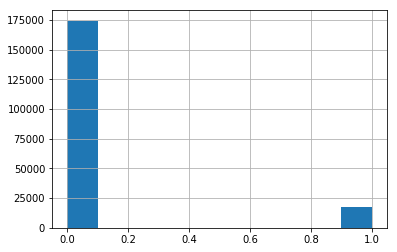

In [43]:
#Some statistics about them
customers['ONLINE_PURCHASE'].hist()

In [44]:
#How many unique values we have 
for i in extra_columns:
    print(customers[i].unique())

['MULTI_BUYER' 'SINGLE_BUYER']
[0 1]
['COSMETIC_AND_FOOD' 'FOOD' 'COSMETIC']


In [45]:
#How many Nan values
customers[extra_columns].isna().sum()

CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
PRODUCT_GROUP      0
dtype: int64

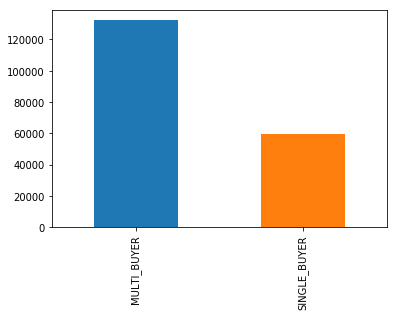

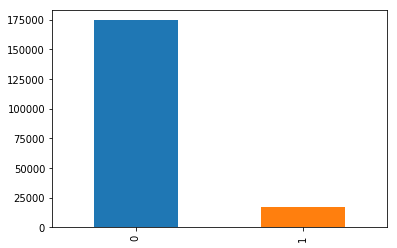

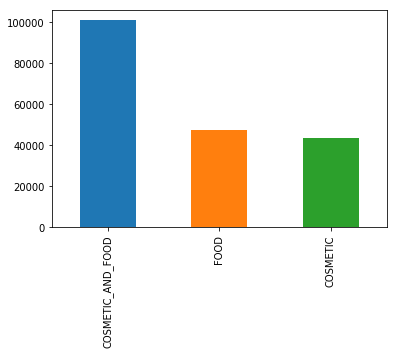

In [46]:
for i in extra_columns:
    customers[i].value_counts().plot(kind='bar')
    plt.show()


# After the analyses it's time to define a function to clean azdias data and reply it to customers data

In [47]:
def clean_columns_azdias(data_1, threshold = 50):
    
    
    #We have two kind of object values OST_WEST_KZ and -1, wich is unknown values 
    data_1['OST_WEST_KZ'].replace(['W', 'O'], [2, 1], inplace=True)
    
    #filter the nan values and order it 
    nan_values = ((data_1.isnull().sum(axis = 0) / data_1.shape[0]) *100).sort_values(ascending=False)
    
    #values under the threshold will be dropped
    under_threshold = nan_values[nan_values > threshold].index #columns with Nan's under the threshold
    clean_1 = data_1.drop(under_threshold, axis=1, inplace=True) #drop this columns
    
    #columns with Nans between half threshold and threshold itself
    half_threshold = nan_values[(nan_values > (threshold / 2)) & (nan_values < threshold)].index
    
    #Start droping columns, specified in half_threshold, with Nan values showed in more than 4 columns
    data_1.dropna(subset=half_threshold, thresh=4, inplace=True)
    
    
    #For columns with small amount of Nan, they will be unknow values: -1
    for col in data_1.columns:
        data_1[col].fillna(-1, inplace=True)
    
    #Cleaning the columns with float
    float_columns = data_1.select_dtypes(include=['float64']).columns
    
    #Clean float values
    for col in float_columns:
            data_1[col] = data_1[col].astype('int')
    
    
    #Replace X with -1 and change this object column to int
    data_1['CAMEO_DEUG_2015'].replace('X', -1, inplace=True)
    data_1['CAMEO_DEUG_2015'] = data_1['CAMEO_DEUG_2015'].astype('int')
    
    
    #For simplicity we will just deal with columns with less than 11 unique values
    for column in data_1.columns:
        if len(data_1[column].unique()) > 11:
            data_1.drop(column, axis=1, inplace=True)
        elif ((data_1[column].isin([0]).sum() / data_1.shape[0]) *100) > 90:
            data_1.drop(column, axis=1, inplace=True)
    

    
    #standarize the unknown values as -1, replacing the 0's
    for col in data_1.columns:
        data_1[col].replace(0, -1, inplace=True)
    #For columns with unique variables between 0 and 8, replace the 9's with -1 
    for col in data_1.columns:
        if len(data_1[col].unique()) < 9:
            data_1[col].replace(9, -1, inplace=True)
    


In [48]:
def drop_different_columns(data_1, data_2):
    
    #Specific columns from customers dataset    
    extra_col = pd.Index(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])
    #Columns not dropped from data_1
    cleaned_columns = data_1.columns
    #The columns we will need in data_2
    all_col = cleaned_columns.append(extra_col)
  #  columns_data_2 = data_2.columns
    
    
    #Drop all columns no included in all_col
    for i in data_2.columns:
        if i not in all_col:
            data_2.drop(columns=i, inplace=True)


In [49]:
def clean_columns_customers(data_2):

    #We have two kind of object values OST_WEST_KZ and -1, wich is unknown values 
    data_2['OST_WEST_KZ'].replace(['W', 'O'], [2, 1], inplace=True)     

    #For columns with small amount of Nan, they will be unknow values: -1
    for col in data_2.columns:
        data_2[col].fillna(-1, inplace=True)


    #Cleaning the columns with float
    float_columns_2 = data_2.select_dtypes(include=['float64']).columns

    #Clean float values
    for col in float_columns_2:
            data_2[col] = data_2[col].astype('int')

    #Replace X with -1 and change this object column to int
    data_2['CAMEO_DEUG_2015'].replace('X', -1, inplace=True)
    data_2['CAMEO_DEUG_2015'] = data_2['CAMEO_DEUG_2015'].astype('int')



    #standarize the unknown values as -1, replacing the 0's
    for col in data_2.columns:
        data_2[col].replace(0, -1, inplace=True)
    #For columns with unique variables between 0 and 8, replace the 9's with -1 
    for col in data_2.columns:
        if len(data_2[col].unique()) < 9:
            data_2[col].replace(9, -1, inplace=True)



In [50]:
clean_columns_azdias(azdias)

In [51]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ANZ_KINDER,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,UMFELD_JUNG,VERS_TYP,VHA,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
2,-1,9,-1,3,2,4,3,2,4,4,...,5,1,-1,2,3,9,2,5,2,3
3,2,1,-1,2,4,2,2,3,2,2,...,5,1,1,-1,-1,9,7,3,2,4
4,-1,1,-1,4,2,6,5,3,3,3,...,3,2,-1,2,2,9,3,4,1,3
5,3,1,-1,2,6,8,2,5,2,1,...,3,2,-1,2,6,9,7,4,2,1
6,-1,9,-1,4,6,4,5,3,5,5,...,5,1,-1,2,3,9,5,4,2,2


In [52]:
drop_different_columns(azdias, customers)

In [53]:
clean_columns_customers(customers)

In [54]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ANZ_KINDER,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,UMFELD_JUNG,VERS_TYP,VHA,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
2,-1,9,-1,3,2,4,3,2,4,4,...,5,1,-1,2,3,9,2,5,2,3
3,2,1,-1,2,4,2,2,3,2,2,...,5,1,1,-1,-1,9,7,3,2,4
4,-1,1,-1,4,2,6,5,3,3,3,...,3,2,-1,2,2,9,3,4,1,3
5,3,1,-1,2,6,8,2,5,2,1,...,3,2,-1,2,6,9,7,4,2,1
6,-1,9,-1,4,6,4,5,3,5,5,...,5,1,-1,2,3,9,5,4,2,2


In [55]:
#Save the cleaned datasets
azdias.to_csv('azdias_cleaned.csv')
customers.to_csv('customers_cleaned.csv')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [56]:
azdias_cleaned = pd.read_csv('azdias_cleaned.csv', index_col=0)
customers_cleaned = pd.read_csv('customers_cleaned.csv', index_col=0)

In [57]:
#To apply data into PCA we need to scale the values(mean = 0 and variance = 1)
scaler = StandardScaler()
# Apply transform
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns)

In [58]:
#To apply scaler and PCA on customers dataset, we need to drop the object columns
customers_cleaned.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [59]:
#Apply scale to customers 
customers_scaled = pd.DataFrame(scaler.transform(customers_cleaned), columns = customers_cleaned.columns)

In [60]:
# performing principle components analysis on the scaled data
#instantiate
pca = PCA()

#Fit azdias scaled into PCA
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

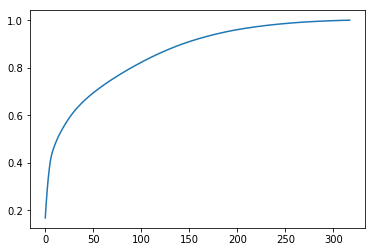

In [61]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [62]:
#Based on this graph, I will keep 120 components (explaining 90% of the data)
n_components = 120

# performing principle components analysis on the scaled data
#instantiate
pca = PCA(n_components=n_components)

#Fit and transform azdias scaled into PCA
azdias_pca = pca.fit_transform(azdias_scaled)
#Tranform customers with the values from azdias fitting
customers_pca = pca.transform(customers_scaled)

In [63]:
PCA_components = pd.DataFrame(azdias_pca)

In [64]:
print(pd.DataFrame(pca.components_,columns=azdias_scaled.columns))

     AGER_TYP  AKT_DAT_KL  ANZ_KINDER    ARBEIT  BALLRAUM  CAMEO_DEUG_2015  \
0   -0.003464    0.004769    0.002839 -0.054645 -0.038469        -0.039384   
1   -0.021531    0.065845   -0.032048  0.094415 -0.073702         0.139523   
2   -0.106581    0.019361    0.075887  0.015807  0.008658         0.022173   
3   -0.065816    0.022421    0.025724 -0.012664 -0.044253         0.002685   
4    0.011649   -0.005564   -0.000826 -0.031645 -0.100822        -0.033830   
5    0.106830   -0.111171   -0.002106  0.079623 -0.049470         0.055052   
6    0.020263   -0.025073   -0.022517  0.018256 -0.014566         0.008452   
7   -0.014075    0.021536    0.000300  0.100654  0.041314        -0.031554   
8    0.019146   -0.016220   -0.008772 -0.117460  0.074012         0.064233   
9    0.024226    0.007478   -0.036076 -0.024281  0.055150         0.012024   
10  -0.023714    0.012989    0.012740 -0.000718  0.002774        -0.062877   
11  -0.019426    0.006749   -0.012824  0.053714  0.016798       

2 142999913.283
3 135125370.656
4 129467511.499
5 118681150.753
6 115973180.092
7 113405196.556
8 112188075.414
9 111163905.015
10 109243919.053
11 110317877.139
12 107155565.887
13 106726408.103
14 105765292.804
15 104957076.703
16 104805003.851
17 104685551.237
18 103986535.497
19 103479611.673
20 102853576.699
21 102284148.438
22 102971777.815
23 101692508.467
24 101415502.186
25 101226458.037
26 100155664.145
27 100408682.814
28 99745102.7491
29 99493108.397
30 99514717.445
31 98951315.167
32 98724717.2897
33 98987424.5834
34 98025716.9235
35 97838275.6907
36 97821569.235
37 97465630.7582
38 97637922.6082
39 97488324.115


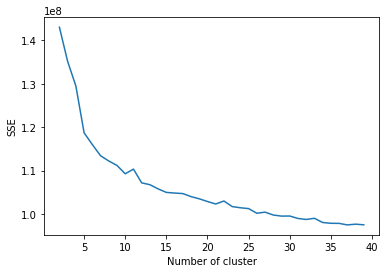

In [65]:
#Using the elbow technic to choose the number of k 
sse = {}
for k in range(2, 40, 1):
    mini_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=300).fit(azdias_pca)
    sse[k] = mini_kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    print(k, sse[k])
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [66]:
#Will you 7 clustes, after that the distances from each value start to get too close
kmeans_7 = KMeans(n_clusters=7)
azdias_pred = kmeans_7.fit_predict(azdias_pca)

In [67]:
customers_pred = kmeans_7.predict(customers_pca)

<Container object of 7 artists>

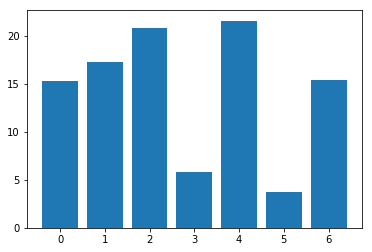

In [68]:
# View how azdias is distributed on the clusters

azdias_count = Counter(azdias_pred)

x = azdias_count.keys() 
y = np.array(list(azdias_count.values())) / len(azdias_pred) * 100
plt.bar(x, y)

<Container object of 7 artists>

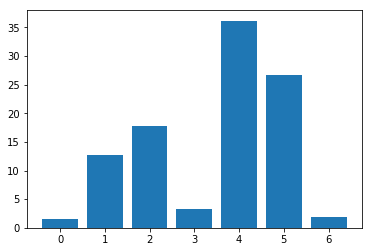

In [69]:
# View how customers is distributed on the clusters

customers_count = Counter(customers_pred)

x = customers_count.keys() 
y = np.array(list(customers_count.values())) / len(customers_pred) * 100
plt.bar(x, y)

We can see that azdias and customers has the 3 cluster as a possible target for future customers

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [70]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [72]:
#See the first lines from our dataset
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


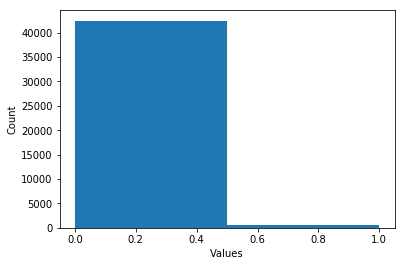

RESPONSE
0    42430
1      532
Name: RESPONSE, dtype: int64


In [73]:
plt.hist(mailout_train['RESPONSE'], bins=2)
plt.ylabel('Count')
plt.xlabel('Values')
plt.show()
print(mailout_train.groupby('RESPONSE')['RESPONSE'].count())

It's possible to see we have an imbalanced data

In [74]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [75]:
#split data into X and y
y_train = mailout_train['RESPONSE']
X_train = mailout_train.drop(labels=['RESPONSE'], axis=1)


In [76]:
X_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3


In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 120.0+ MB


In [78]:
#count how many Nan values we have in each column
nan_values_X_train = ((X_train.isnull().sum(axis = 0) / X_train.shape[0]) *100).sort_values(ascending=False)
nan_values_X_train

ALTER_KIND4                  99.904567
ALTER_KIND3                  99.594991
ALTER_KIND2                  98.240305
ALTER_KIND1                  95.372655
KK_KUNDENTYP                 58.926493
EXTSEL992                    37.121177
HH_DELTA_FLAG                22.526884
W_KEIT_KIND_HH               22.526884
KBA05_MAXVORB                20.129417
KBA05_MOTOR                  20.129417
KBA05_MOD4                   20.129417
KBA05_MOD3                   20.129417
KBA05_MOD2                   20.129417
KBA05_MOD1                   20.129417
KBA05_MAXSEG                 20.129417
KBA05_KRSZUL                 20.129417
KBA05_MOTRAD                 20.129417
KBA05_MAXBJ                  20.129417
KBA05_MAXAH                  20.129417
KBA05_KW3                    20.129417
KBA05_KW2                    20.129417
MOBI_REGIO                   20.129417
KBA05_KW1                    20.129417
KBA05_MAXHERST               20.129417
KBA05_ZUL3                   20.129417
KBA05_SEG1               

In [79]:
#See unique values and how they are spread in the dataset 
for i in X_train.columns:
    print(i,'\n', X_train[i].unique(), len(X_train[i].unique()))

LNR 
 [ 1763  1771  1776 ..., 68273 68581 69224] 42962
AGER_TYP 
 [ 2  1  3 -1  0] 5
AKT_DAT_KL 
 [  1.   4.  nan   7.   5.   9.   3.   2.   6.   8.] 10
ALTER_HH 
 [  8.  13.   9.   6.  12.  nan  15.  20.  21.  11.  19.  17.  10.   0.   5.
   7.  16.  18.  14.   4.   3.] 21
ALTER_KIND1 
 [ nan  13.   7.  14.   8.  18.  17.   9.  10.  16.   2.  15.  11.  12.   6.
   5.   4.   3.] 18
ALTER_KIND2 
 [ nan  16.  15.  17.  10.  18.   9.  14.  12.  11.  13.   8.   7.   5.   6.] 15
ALTER_KIND3 
 [ nan  15.  18.  13.  10.  11.  16.  12.  17.  14.   6.   7.   8.] 13
ALTER_KIND4 
 [ nan  15.  18.  13.  11.  14.  17.  16.   6.  12.   7.  10.] 12
ALTERSKATEGORIE_FEIN 
 [  8.  13.   7.   6.   9.  12.  nan  16.  11.  17.  15.   0.   5.  10.  18.
  14.  19.  21.  20.   4.   3.  23.  25.  24.  22.   2.] 26
ANZ_HAUSHALTE_AKTIV 
 [  15.    1.    0.    4.   53.   17.    2.   nan    8.    3.    5.    9.
    6.  116.   80.   20.   19.   54.   13.   10.   30.   14.   92.   12.
   18.    7.   11.   16.   45. 

In [80]:
#Drop the same columns we dropped from azdias and customers dataset
cleaned_columns = azdias_cleaned.columns
cleaned_columns
X_train.drop(columns=[col for col in X_train if col not in cleaned_columns ], inplace=True)

In [81]:
#Replace object values with int
X_train['OST_WEST_KZ'].replace(['W', 'O'], [2, 1], inplace=True)

In [82]:
#Replace X with -1 on CAMEO_DEUG_2015 
X_train['CAMEO_DEUG_2015'].replace('X', -1, inplace=True)

In [83]:
#Standardize the values filling Nan, change to intm replace 0 with -1 and replace 9 with -1 if unique values less than 9
for col in X_train.columns:
        X_train[col].fillna(-1, inplace=True)
        
        X_train[col] = X_train[col].astype('int')
        
        X_train[col].replace(0, -1, inplace=True)
        
        if len(X_train[col].unique()) < 9:
            X_train[col].replace(9, -1, inplace=True)

We have an inbalanced data, for that it's necessary to resample all to improve the algorithm

In [84]:
# setting up testing and training sets
X_train_res, X_valid_res, y_train_res, y_valid_res = train_test_split(X_train, y_train, test_size=0.25, random_state=27)

# concatenate our training data back together
X = pd.concat([X_train_res, y_train_res], axis=1)

# separate minority and majority classes
not_customer = X[X.RESPONSE == 0]
customer = X[X.RESPONSE == 1]

# upsample minority
upsampled = resample(customer,
                    replace=True, # sample with replacement
                    n_samples=len(not_customer), # match number in majority class
                    random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_customer, upsampled])

In [85]:
upsampled.RESPONSE.value_counts()

1    31828
0    31828
Name: RESPONSE, dtype: int64

In [86]:
# trying logistic regression with the balanced dataset
y_train = upsampled.RESPONSE
X_train = upsampled.drop('RESPONSE', axis=1)


LogReg = LogisticRegression(solver='liblinear').fit(X_train, y_train)

y_pred = LogReg.predict(X_valid_res)




In [87]:
y_pred

array([1, 0, 1, ..., 0, 0, 0])

In [88]:
# Checking accuracy
print(accuracy_score(y_valid_res, y_pred))
    
# f1 score
print(f1_score(y_valid_res, y_pred))

#auc
print(roc_auc_score(y_valid_res, y_pred))

0.70645191323
0.0372519083969
0.574404652848


In [89]:
# RandomForestClassifier
rfc = RandomForestClassifier().fit(X_train, y_train)

y_pred = rfc.predict(X_valid_res)


In [90]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [91]:
# Checking accuracy
print(accuracy_score(y_valid_res, y_pred))
    
# f1 score
print(f1_score(y_valid_res, y_pred))

#auc
print(roc_auc_score(y_valid_res, y_pred))

0.944884089005
0.023102310231
0.503485836119


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [92]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [94]:
lnr = mailout_test.LNR

In [95]:
#Drop the same columns we dropped from azdias and customers dataset
cleaned_columns = azdias_cleaned.columns
cleaned_columns
mailout_test.drop(columns=[col for col in mailout_test if col not in cleaned_columns ], inplace=True)

In [96]:
#Replace object values with int
mailout_test['OST_WEST_KZ'].replace(['W', 'O'], [2, 1], inplace=True)

In [97]:
#Replace X with -1 on CAMEO_DEUG_2015 
mailout_test['CAMEO_DEUG_2015'].replace('X', -1, inplace=True)

In [98]:
#Standardize the values filling Nan, change to intm replace 0 with -1 and replace 9 with -1 if unique values less than 9
for col in mailout_test.columns:
        mailout_test[col].fillna(-1, inplace=True)
        
        mailout_test[col] = mailout_test[col].astype('int')
        
        mailout_test[col].replace(0, -1, inplace=True)
        
        if len(mailout_test[col].unique()) < 9:
            mailout_test[col].replace(9, -1, inplace=True)

In [99]:
#verify if there's any Nan value
mailout_test.isna().sum()

AGER_TYP                    0
AKT_DAT_KL                  0
ANZ_KINDER                  0
ARBEIT                      0
BALLRAUM                    0
CAMEO_DEUG_2015             0
CJT_GESAMTTYP               0
CJT_KATALOGNUTZER           0
CJT_TYP_1                   0
CJT_TYP_2                   0
CJT_TYP_3                   0
CJT_TYP_4                   0
CJT_TYP_5                   0
CJT_TYP_6                   0
D19_BANKEN_ANZ_24           0
D19_BANKEN_DATUM            0
D19_BANKEN_DIREKT           0
D19_BANKEN_GROSS            0
D19_BANKEN_OFFLINE_DATUM    0
D19_BANKEN_ONLINE_DATUM     0
D19_BANKEN_REST             0
D19_BEKLEIDUNG_GEH          0
D19_BEKLEIDUNG_REST         0
D19_BILDUNG                 0
D19_BUCH_CD                 0
D19_DROGERIEARTIKEL         0
D19_FREIZEIT                0
D19_GESAMT_ANZ_12           0
D19_GESAMT_ANZ_24           0
D19_GESAMT_DATUM            0
                           ..
RT_KEIN_ANREIZ              0
RT_SCHNAEPPCHEN             0
RT_UEBERGR

In [100]:
#Predicting the probabilitie of the value
response = LogReg.predict_proba(mailout_test)

In [101]:
# generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response[:,0]})
result.to_csv('result.csv', index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.264957
1,1770,0.825880
2,1465,0.964883
3,1470,0.906190
4,1478,0.450848
5,1782,0.955623
6,1485,0.541748
7,1519,0.970815
8,1835,0.587221
9,1522,0.885812
